# Is there a gender gap in decentralized microfinance?
## Evidence from the crowdsourcing platform Kiva

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import scipy.stats as sts
%matplotlib inline

In [134]:
pd.set_option('display.max_rows', 1000)

In [77]:
data = pd.read_csv('data/loans.csv', usecols = ['LOAN_ID','LOAN_AMOUNT', 'STATUS', 'SECTOR_NAME',
                                                'COUNTRY_NAME', 'POSTED_TIME', 'RAISED_TIME',
                                                'NUM_LENDERS_TOTAL','BORROWER_GENDERS', 'BORROWER_PICTURED',
                                                'REPAYMENT_INTERVAL','DISTRIBUTION_MODEL'],
                   parse_dates=['POSTED_TIME','RAISED_TIME'])

### Exploratory Data Analysis

In [78]:
for col in data[['STATUS', 'SECTOR_NAME', 'COUNTRY_NAME','BORROWER_GENDERS',
       'BORROWER_PICTURED', 'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL']].columns:
    print(col,data[col].unique())

STATUS ['funded' 'expired' 'fundRaising' 'refunded']
SECTOR_NAME ['Food' 'Housing' 'Health' 'Education' 'Retail' 'Agriculture' 'Services'
 'Personal Use' 'Arts' 'Clothing' 'Transportation' 'Wholesale'
 'Construction' 'Entertainment' 'Manufacturing']
COUNTRY_NAME ['Philippines' 'Solomon Islands' 'Uganda' 'Kenya' 'Mexico' 'Pakistan'
 'Colombia' 'Vietnam' 'Peru' 'Tajikistan' 'Indonesia' 'Cambodia' 'Armenia'
 'Liberia' 'Timor-Leste' 'Ghana' 'Samoa' 'Lebanon' 'El Salvador'
 'Costa Rica' 'Bolivia' 'Madagascar' 'United States' 'Paraguay' 'Georgia'
 'Azerbaijan' 'Ecuador' 'Nigeria' 'Tanzania' 'Kyrgyzstan' 'Nicaragua'
 'Togo' 'Albania' 'Mali' 'Sierra Leone' 'Palestine' 'Rwanda' 'Chile'
 'Zimbabwe' 'Nepal' 'India' 'Mozambique' 'Fiji' 'Jordan' 'Tonga' 'Haiti'
 'Lesotho' 'Benin' 'Iraq' 'Honduras' 'Turkey'
 'The Democratic Republic of the Congo' 'Burkina Faso' 'Senegal' 'Moldova'
 'Egypt' 'Cameroon' 'Mongolia' 'Yemen' 'South Sudan' 'Ukraine' 'Sri Lanka'
 'Kosovo' 'Puerto Rico' 'Guatemala' 'Zambia'


In [79]:
data = data[((data['RAISED_TIME'].dt.year>=2010)&(data['RAISED_TIME'].dt.year<=2020)&(data['POSTED_TIME'].dt.year>=2010)&(data['POSTED_TIME'].dt.year<=2020)&(data['STATUS'].isin(['funded','expired']))&(data['DISTRIBUTION_MODEL']=='field_partner')&(data['BORROWER_GENDERS'].isin(['male','female'])))]

In [80]:
# data = data[data['LOAN_AMOUNT']<=5500]

In [81]:
country_totals = data[['COUNTRY_NAME','LOAN_ID']].groupby('COUNTRY_NAME').count().sort_values('LOAN_ID',ascending=False).reset_index()
country_totals['share']=(country_totals['LOAN_ID']/data['LOAN_ID'].nunique())
# country_totals[country_totals['share']>=.01]['COUNTRY_NAME']


In [82]:
loan_totals = data[['LOAN_AMOUNT','LOAN_ID']].groupby('LOAN_AMOUNT').count().sort_values('LOAN_ID',ascending=False).reset_index()
loan_totals['share']=(loan_totals['LOAN_ID']/data['LOAN_ID'].nunique())*100
# loan_totals

In [83]:
sector_totals = data[['SECTOR_NAME','LOAN_ID']].groupby('SECTOR_NAME').count().sort_values('LOAN_ID',ascending=False).reset_index()
sector_totals['share']=(sector_totals['LOAN_ID']/data['LOAN_ID'].nunique())*100
# sector_totals


In [84]:
data = data[((data['STATUS']=='funded')&(data['DISTRIBUTION_MODEL']=='field_partner')&(data['BORROWER_GENDERS'].isin(['male','female']))&(data['COUNTRY_NAME'].isin(country_totals[country_totals['share']>=.01]['COUNTRY_NAME']))&(data['LOAN_AMOUNT'].isin(loan_totals[loan_totals['share']>=.01]['LOAN_AMOUNT']))&(data['SECTOR_NAME'].isin(sector_totals[sector_totals['share']>=.01]['SECTOR_NAME'])))]

In [85]:
data.describe()

,LOAN_ID,LOAN_AMOUNT,NUM_LENDERS_TOTAL
count,1.232239e+06,1.232239e+06,1.232239e+06
mean,1.142227e+06,5.188247e+02,1.509632e+01
std,5.570388e+05,4.149715e+02,1.327170e+01
min,1.662600e+05,2.500000e+01,1.000000e+00
25%,6.588685e+05,2.250000e+02,6.000000e+00
50%,1.161094e+06,4.000000e+02,1.100000e+01
75%,1.627186e+06,6.500000e+02,2.000000e+01
max,2.084051e+06,1.000000e+04,3.460000e+02


### Variable creation and descriptives

In [86]:
# Year
data['year'] = data['RAISED_TIME'].dt.year

In [87]:
# Gender
# data['gender'] = np.where(data['BORROWER_GENDERS']=='female', 0, 1)
data['gender'] = data['BORROWER_GENDERS'].astype("category").cat.codes

In [88]:
# Pandemic
data['pandemic'] = np.where(data['POSTED_TIME'].dt.year.isin([2020]),1,0)

In [89]:
# Pandemic - Gender interaction
data['pandemic_gender'] = data['pandemic']*data['gender']

In [90]:
# Difference between posted and raised time
data['days_to_funding'] = data['RAISED_TIME'].sub(data['POSTED_TIME'], axis=0)
data['days_to_funding'] = data['days_to_funding'] / np.timedelta64(1, 'D')

In [91]:
data['days_to_funding_2'] = data['days_to_funding']*data['days_to_funding']

In [92]:
# Number of lenders
data['NUM_LENDERS_TOTAL_2'] = data['NUM_LENDERS_TOTAL'] * data['NUM_LENDERS_TOTAL']

In [93]:
# Borrower pictured
data['picture'] = np.where(data['BORROWER_PICTURED']=='false', 0, 1)

In [94]:
data['picture_gender'] = data['picture'] * data['gender']

In [95]:
# data.head()

In [96]:
data_year_mean = data.groupby(['year','gender']).mean().reset_index()

In [97]:
data_year_count = data.groupby(['year','gender']).count().reset_index()

In [98]:
data_year_count_pct = data[['year','gender','LOAN_ID']].groupby(['year','gender']).count().reset_index().rename(columns={'LOAN_ID':'count'}).merge(data[['year','LOAN_ID']].groupby(['year']).count().reset_index().rename(columns={'LOAN_ID':'total'}),how='left',on='year')
data_year_count_pct['percent']=data_year_count_pct['count']/data_year_count_pct['total']*100
data_year_count_pct = data_year_count_pct[['year','percent','gender']].pivot(index='year',columns='gender').reset_index()


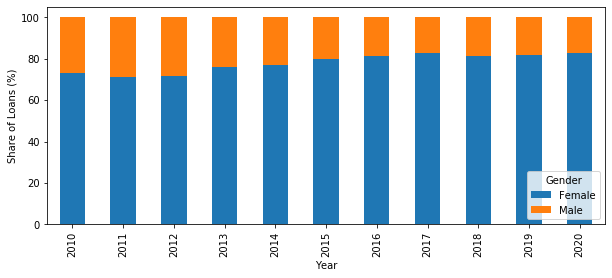

In [99]:
data_year_count_pct.plot(x='year',y='percent', kind='bar', stacked=True, figsize=(10,4))
plt.ylabel('Share of Loans (%)')
plt.xlabel('Year')
plt.legend(title='Gender', labels = ['Female','Male'], loc='lower right');

In [100]:
data_year_count_pct = data[data['SECTOR_NAME']=='Personal Use'][['year','gender','LOAN_ID']].groupby(['year','gender']).count().reset_index().rename(columns={'LOAN_ID':'count'}).merge(data[data['SECTOR_NAME']=='Personal Use'][['year','LOAN_ID']].groupby(['year']).count().reset_index().rename(columns={'LOAN_ID':'total'}),how='left',on='year')
data_year_count_pct['percent']=data_year_count_pct['count']/data_year_count_pct['total']*100
data_year_count_pct = data_year_count_pct[['year','percent','gender']].pivot(index='year',columns='gender').reset_index()


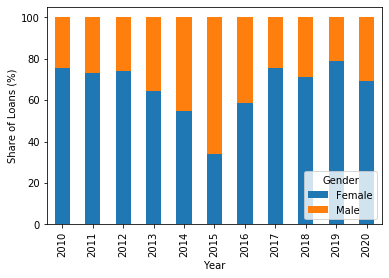

In [101]:
data_year_count_pct.plot(x='year',y='percent', kind='bar', stacked=True, figsize=(6,4))
plt.ylabel('Share of Loans (%)')
plt.xlabel('Year')
plt.legend(title='Gender', labels = ['Female','Male'], loc='lower right');

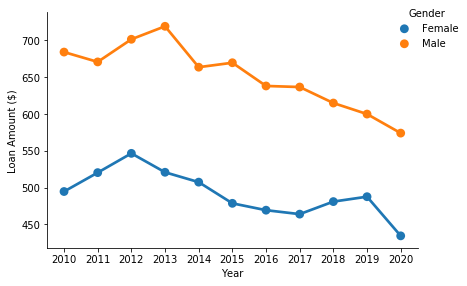

In [102]:
g = sns.catplot(x="year", y="LOAN_AMOUNT", hue="gender", kind="point", data=data_year_mean, height=4, aspect=12/8)
plt.ylabel('Loan Amount ($)')
plt.xlabel('Year')
# title
new_title = 'Gender'
g._legend.set_title(new_title)
# labels
new_labels = ['Female', 'Male']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
g._legend._loc = 1;

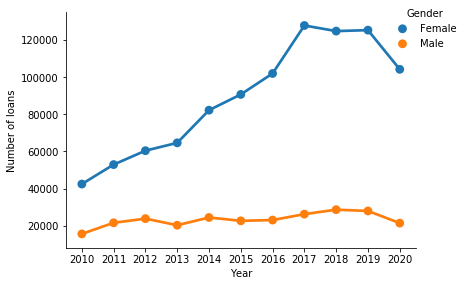

In [103]:
g = sns.catplot(x="year", y="LOAN_AMOUNT", hue="gender", kind="point", data=data_year_count, height=4, aspect=12/8)
plt.ylabel('Number of loans')
plt.xlabel('Year')
# title
new_title = 'Gender'
g._legend.set_title(new_title)
# labels
new_labels = ['Female', 'Male']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
g._legend._loc = 1;

In [104]:
data_sector_count_pct = data[['SECTOR_NAME','gender','LOAN_ID']].groupby(['SECTOR_NAME','gender']).count().reset_index().rename(columns={'LOAN_ID':'count'}).merge(data[['SECTOR_NAME','LOAN_ID']].groupby(['SECTOR_NAME']).count().reset_index().rename(columns={'LOAN_ID':'total'}),how='left',on='SECTOR_NAME')
data_sector_count_pct['percent']=data_sector_count_pct['count']/data_sector_count_pct['total']*100
data_sector_count_pct = data_sector_count_pct[['SECTOR_NAME','percent','gender']].pivot(index='SECTOR_NAME',columns='gender').reset_index()


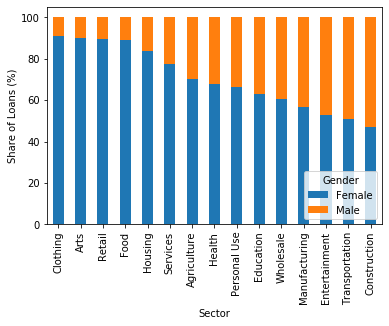

In [105]:
data_sector_count_pct.sort_values(by=[('percent',1)]).plot(x='SECTOR_NAME',y='percent', kind='bar', stacked=True, figsize=(6,4))
plt.ylabel('Share of Loans (%)')
plt.xlabel('Sector')
plt.legend(title='Gender', labels = ['Female','Male'], loc='lower right');

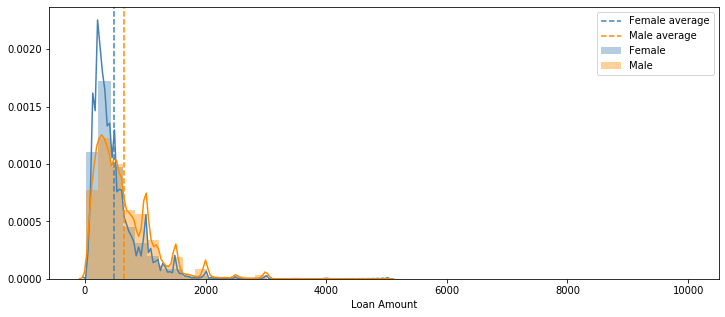

In [106]:
# LOAN AMOUNT
plt.figure(figsize=(12,5))
sns.distplot(data[data['gender']==0]['LOAN_AMOUNT'], hist=True, color='steelblue', label = 'Female', kde_kws={'clip': (0, 6000)})
sns.distplot(data[data['gender']==1]['LOAN_AMOUNT'], hist=True, color='darkorange', label = 'Male', kde_kws={'clip': (0, 6000)})
plt.axvline(data[data['gender']==0]['LOAN_AMOUNT'].mean(), color="steelblue", label = 'Female average',  linestyle="--")
plt.axvline(data[data['gender']==1]['LOAN_AMOUNT'].mean(), color="darkorange", label = 'Male average', linestyle="--")
plt.xlabel('Loan Amount')
plt.legend();

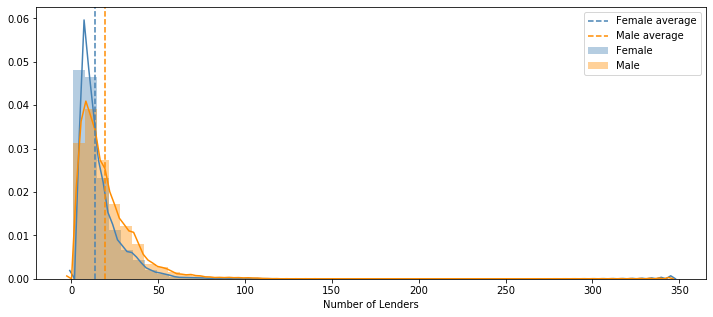

In [107]:
# NUMBER OF LENDERS
plt.figure(figsize=(12,5))
sns.distplot(data[data['gender']==0]['NUM_LENDERS_TOTAL'], hist=True, color='steelblue', label = 'Female', kde_kws={'clip': (0, 6000)})
sns.distplot(data[data['gender']==1]['NUM_LENDERS_TOTAL'], hist=True, color='darkorange', label = 'Male', kde_kws={'clip': (0, 6000)})
plt.axvline(data[data['gender']==0]['NUM_LENDERS_TOTAL'].mean(), color="steelblue", label = 'Female average', linestyle="--")
plt.axvline(data[data['gender']==1]['NUM_LENDERS_TOTAL'].mean(), color="darkorange", label = 'Male average', linestyle="--")
plt.xlabel('Number of Lenders')
plt.legend();

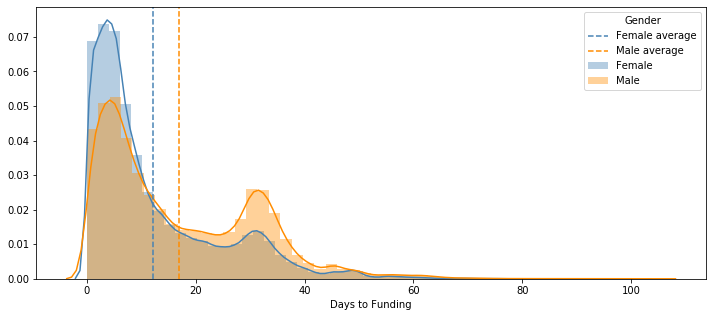

In [108]:
# DAYS TO FUNDING
plt.figure(figsize=(12,5))
sns.distplot(data[data['gender']==0]['days_to_funding'], hist=True, color='steelblue', label = 'Female', kde_kws={'clip': (0, 6000)})
sns.distplot(data[data['gender']==1]['days_to_funding'], hist=True, color='darkorange', label = 'Male', kde_kws={'clip': (0, 6000)})
plt.axvline(data[data['gender']==0]['days_to_funding'].mean(), color="steelblue", label = 'Female average', linestyle="--")
plt.axvline(data[data['gender']==1]['days_to_funding'].mean(), color="darkorange", label = 'Male average', linestyle="--")
plt.xlabel('Days to Funding')
plt.legend(title = 'Gender');

In [109]:
data_country_mean = data.groupby(['COUNTRY_NAME','gender']).mean().reset_index()

In [110]:
data_sector_mean = data.groupby(['SECTOR_NAME','gender']).mean().reset_index()

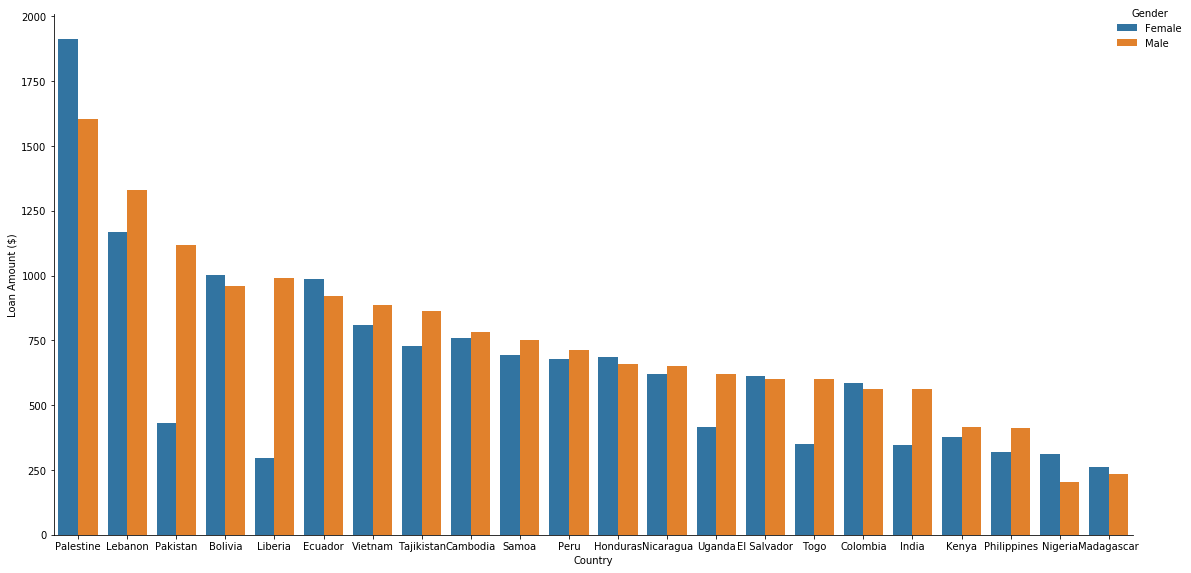

In [111]:
g = sns.catplot(x="COUNTRY_NAME", y="LOAN_AMOUNT", hue="gender", kind="bar", data=data_country_mean.sort_values(by='LOAN_AMOUNT',ascending=False), height=8, aspect=16/8)
plt.ylabel('Loan Amount ($)')
plt.xlabel('Country')
# title
new_title = 'Gender'
g._legend.set_title(new_title)
# labels
new_labels = ['Female', 'Male']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
g._legend._loc = 1;

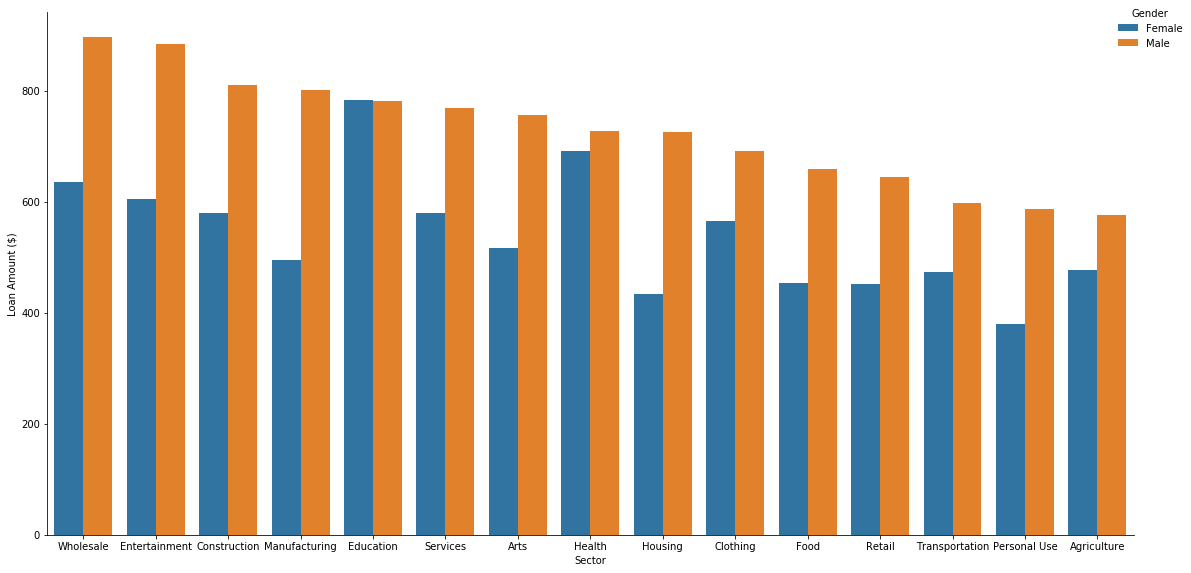

In [112]:
g = sns.catplot(x="SECTOR_NAME", y="LOAN_AMOUNT", hue="gender", kind="bar", data=data_sector_mean.sort_values(by='LOAN_AMOUNT',ascending=False), height=8, aspect=16/8)
plt.ylabel('Loan Amount ($)')
plt.xlabel('Sector')
# title
new_title = 'Gender'
g._legend.set_title(new_title)
# labels
new_labels = ['Female', 'Male']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
g._legend._loc = 1;

In [113]:
n_loans = data[['COUNTRY_NAME','LOAN_AMOUNT']].groupby('COUNTRY_NAME').count().reset_index().rename(columns={'LOAN_AMOUNT':'Total Number of Loans','COUNTRY_NAME':'Country'})
n_loans_female = data[data['gender']==0][['COUNTRY_NAME','LOAN_AMOUNT']].groupby('COUNTRY_NAME').count().reset_index().rename(columns={'LOAN_AMOUNT':'Number of Loans - Female','COUNTRY_NAME':'Country'})
n_loans_male = data[data['gender']==1][['COUNTRY_NAME','LOAN_AMOUNT']].groupby('COUNTRY_NAME').count().reset_index().rename(columns={'LOAN_AMOUNT':'Number of Loans - Male','COUNTRY_NAME':'Country'})
mean_loans_female = data[data['gender']==0][['COUNTRY_NAME','LOAN_AMOUNT']].groupby('COUNTRY_NAME').mean().reset_index().rename(columns={'LOAN_AMOUNT':'Mean Loan Amount - Female','COUNTRY_NAME':'Country'})
mean_loans_male = data[data['gender']==1][['COUNTRY_NAME','LOAN_AMOUNT']].groupby('COUNTRY_NAME').mean().reset_index().rename(columns={'LOAN_AMOUNT':'Mean Loan Amount - Male','COUNTRY_NAME':'Country'})


In [114]:
summary_stats = n_loans.merge(n_loans_female,on='Country',how='left').merge(n_loans_male,on='Country',how='left').merge(mean_loans_female,on='Country',how='left').merge(mean_loans_male,on='Country',how='left')


In [115]:
summary_stats['Share of Loans - Female'] = summary_stats['Number of Loans - Female']/summary_stats['Total Number of Loans']*100
summary_stats['Share of Loans - Male'] = summary_stats['Number of Loans - Male']/summary_stats['Total Number of Loans']*100

In [116]:
summary_stats[['Country','Total Number of Loans','Share of Loans - Female','Share of Loans - Male','Mean Loan Amount - Female','Mean Loan Amount - Male']].round(1).rename(columns={'Share of Loans - Female':'Share of Loans - Female (%)','Share of Loans - Male':'Share of Loans - Male (%)','Mean Loan Amount - Female':'Mean Loan Amount - Female ($)','Mean Loan Amount - Male':'Mean Loan Amount - Male ($)'}).sort_values(by='Total Number of Loans',ascending=False)

,Country,Total Number of Loans,Share of Loans - Female (%),Share of Loans - Male (%),Mean Loan Amount - Female ($),Mean Loan Amount - Male ($)
16,Philippines,404786,94.2,5.8,321.1,412.0
7,Kenya,166766,74.0,26.0,376.3,415.0
4,El Salvador,73790,63.2,36.8,611.6,601.2
15,Peru,63168,67.8,32.2,677.5,713.4
20,Uganda,54841,57.2,42.8,417.5,620.6
18,Tajikistan,52956,70.0,30.0,729.5,864.8
3,Ecuador,48622,79.0,21.0,986.4,919.9
13,Pakistan,46625,95.7,4.3,429.5,1116.3
2,Colombia,46514,62.9,37.1,587.4,560.8
1,Cambodia,35564,83.3,16.7,758.6,781.0


In [117]:
def dummify(df, col_list):
    for col in col_list:
        dummies = pd.get_dummies(df[col],prefix=col)
        df[dummies.columns] = dummies
    return df

In [118]:
data = dummify(data,['SECTOR_NAME','COUNTRY_NAME'])

In [119]:
def logify(df, col_list):
    for col in col_list:
        df[col+'_log'] = np.log(df[col]+1)
    return df

In [120]:
data = logify(data,['LOAN_AMOUNT','NUM_LENDERS_TOTAL','days_to_funding'])

In [121]:
for sector in data[['SECTOR_NAME_Agriculture', 'SECTOR_NAME_Arts', 'SECTOR_NAME_Clothing',
       'SECTOR_NAME_Construction', 'SECTOR_NAME_Education',
       'SECTOR_NAME_Entertainment', 'SECTOR_NAME_Food', 'SECTOR_NAME_Health',
       'SECTOR_NAME_Housing', 'SECTOR_NAME_Manufacturing',
       'SECTOR_NAME_Personal Use', 'SECTOR_NAME_Retail',
       'SECTOR_NAME_Services', 'SECTOR_NAME_Transportation', 'SECTOR_NAME_Food',
       'SECTOR_NAME_Wholesale']].columns:
    data[sector+'_gender'] = data[sector]*data['gender']

### Model

In [122]:
data.columns

Index(['LOAN_ID', 'LOAN_AMOUNT', 'STATUS', 'SECTOR_NAME', 'COUNTRY_NAME',
       'POSTED_TIME', 'RAISED_TIME', 'NUM_LENDERS_TOTAL', 'BORROWER_GENDERS',
       'BORROWER_PICTURED', 'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'year',
       'gender', 'pandemic', 'pandemic_gender', 'days_to_funding',
       'days_to_funding_2', 'NUM_LENDERS_TOTAL_2', 'picture', 'picture_gender',
       'SECTOR_NAME_Agriculture', 'SECTOR_NAME_Arts', 'SECTOR_NAME_Clothing',
       'SECTOR_NAME_Construction', 'SECTOR_NAME_Education',
       'SECTOR_NAME_Entertainment', 'SECTOR_NAME_Food', 'SECTOR_NAME_Health',
       'SECTOR_NAME_Housing', 'SECTOR_NAME_Manufacturing',
       'SECTOR_NAME_Personal Use', 'SECTOR_NAME_Retail',
       'SECTOR_NAME_Services', 'SECTOR_NAME_Transportation',
       'SECTOR_NAME_Wholesale', 'COUNTRY_NAME_Bolivia',
       'COUNTRY_NAME_Cambodia', 'COUNTRY_NAME_Colombia',
       'COUNTRY_NAME_Ecuador', 'COUNTRY_NAME_El Salvador',
       'COUNTRY_NAME_Honduras', 'COUNTRY_NAME_India', 'C

In [123]:
data['constant'] = 1

In [124]:
# BASELINE
y = data['LOAN_AMOUNT_log']
X = data[['gender', 'constant']]

model_1 = sm.OLS(y, X).fit()
predictions = model_1.predict(X) 

print_model_1 = model_1.summary()
print(print_model_1)

                            OLS Regression Results                            
Dep. Variable:        LOAN_AMOUNT_log   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                 2.596e+04
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:52:07   Log-Likelihood:            -1.3597e+06
No. Observations:             1232239   AIC:                         2.719e+06
Df Residuals:                 1232237   BIC:                         2.720e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
gender         0.2612      0.002    161.110      0.0

In [125]:
# NO INTERACTIONS + COUNTRY FE
y = data['LOAN_AMOUNT_log']
X = data[['gender',
       'COUNTRY_NAME_Bolivia',
       'COUNTRY_NAME_Cambodia', 'COUNTRY_NAME_Colombia',
       'COUNTRY_NAME_Ecuador', 'COUNTRY_NAME_El Salvador',
       'COUNTRY_NAME_Honduras', 'COUNTRY_NAME_India', 'COUNTRY_NAME_Kenya',
       'COUNTRY_NAME_Lebanon', 'COUNTRY_NAME_Liberia',
       'COUNTRY_NAME_Madagascar', 'COUNTRY_NAME_Nicaragua',
       'COUNTRY_NAME_Nigeria', 'COUNTRY_NAME_Pakistan',
       'COUNTRY_NAME_Palestine', 'COUNTRY_NAME_Peru', 'COUNTRY_NAME_Samoa',
       'COUNTRY_NAME_Tajikistan', 'COUNTRY_NAME_Togo', 'COUNTRY_NAME_Uganda',
       'COUNTRY_NAME_Vietnam', 'constant']]

model_2 = sm.OLS(y, X).fit()
predictions = model_2.predict(X) 

print_model_2 = model_2.summary()
print(print_model_2)

                            OLS Regression Results                            
Dep. Variable:        LOAN_AMOUNT_log   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                 3.158e+04
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:52:10   Log-Likelihood:            -1.0971e+06
No. Observations:             1232239   AIC:                         2.194e+06
Df Residuals:                 1232216   BIC:                         2.194e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
gender                  

In [126]:
# NO INTERACTIONS + SECTOR FE
y = data['LOAN_AMOUNT_log']
X = data[['gender',
       'SECTOR_NAME_Agriculture', 'SECTOR_NAME_Arts', 'SECTOR_NAME_Clothing',
       'SECTOR_NAME_Construction', 'SECTOR_NAME_Education',
       'SECTOR_NAME_Entertainment', 'SECTOR_NAME_Food', 'SECTOR_NAME_Health',
       'SECTOR_NAME_Housing', 'SECTOR_NAME_Manufacturing',
       'SECTOR_NAME_Retail',
       'SECTOR_NAME_Services', 'SECTOR_NAME_Transportation',
       'SECTOR_NAME_Wholesale',
          'constant']]

model_3 = sm.OLS(y, X).fit()
predictions = model_3.predict(X) 

print_model_3 = model_3.summary()
print(print_model_3)

                            OLS Regression Results                            
Dep. Variable:        LOAN_AMOUNT_log   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     4879.
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:52:11   Log-Likelihood:            -1.3370e+06
No. Observations:             1232239   AIC:                         2.674e+06
Df Residuals:                 1232223   BIC:                         2.674e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
gender              

In [127]:
# NO INTERACTIONS + COUNTRY AND SECTOR FE
y = data['LOAN_AMOUNT_log']
X = data[['gender',
       'SECTOR_NAME_Agriculture', 'SECTOR_NAME_Arts', 'SECTOR_NAME_Clothing',
       'SECTOR_NAME_Construction', 'SECTOR_NAME_Education',
       'SECTOR_NAME_Entertainment', 'SECTOR_NAME_Food', 'SECTOR_NAME_Health',
       'SECTOR_NAME_Housing', 'SECTOR_NAME_Manufacturing',
       'SECTOR_NAME_Retail',
       'SECTOR_NAME_Services', 'SECTOR_NAME_Transportation',
       'SECTOR_NAME_Wholesale',
       'COUNTRY_NAME_Bolivia',
       'COUNTRY_NAME_Cambodia', 'COUNTRY_NAME_Colombia',
       'COUNTRY_NAME_Ecuador', 'COUNTRY_NAME_El Salvador',
       'COUNTRY_NAME_Honduras', 'COUNTRY_NAME_India', 'COUNTRY_NAME_Kenya',
       'COUNTRY_NAME_Lebanon', 'COUNTRY_NAME_Liberia',
       'COUNTRY_NAME_Madagascar', 'COUNTRY_NAME_Nicaragua',
       'COUNTRY_NAME_Nigeria', 'COUNTRY_NAME_Pakistan',
       'COUNTRY_NAME_Palestine', 'COUNTRY_NAME_Peru', 'COUNTRY_NAME_Samoa',
       'COUNTRY_NAME_Tajikistan', 'COUNTRY_NAME_Togo', 'COUNTRY_NAME_Uganda',
       'COUNTRY_NAME_Vietnam', 'constant']]

model_4 = sm.OLS(y, X).fit()
predictions = model_4.predict(X) 

print_model_4 = model_4.summary()
print(print_model_4)

                            OLS Regression Results                            
Dep. Variable:        LOAN_AMOUNT_log   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                 2.108e+04
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:52:14   Log-Likelihood:            -1.0769e+06
No. Observations:             1232239   AIC:                         2.154e+06
Df Residuals:                 1232202   BIC:                         2.154e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
gender              

In [128]:
# INTERACTIONS AND FE
y = data['LOAN_AMOUNT_log']
X = data[['gender', 'days_to_funding','days_to_funding_2','NUM_LENDERS_TOTAL','NUM_LENDERS_TOTAL_2',
          'picture','pandemic', 'pandemic_gender',
          'SECTOR_NAME_Agriculture', 'SECTOR_NAME_Arts', 'SECTOR_NAME_Clothing',
       'SECTOR_NAME_Construction', 'SECTOR_NAME_Education',
       'SECTOR_NAME_Entertainment', 'SECTOR_NAME_Food', 'SECTOR_NAME_Health',
       'SECTOR_NAME_Housing', 'SECTOR_NAME_Manufacturing',
       'SECTOR_NAME_Retail',
       'SECTOR_NAME_Services', 'SECTOR_NAME_Transportation',
       'SECTOR_NAME_Wholesale',
       'SECTOR_NAME_Agriculture_gender',
       'SECTOR_NAME_Arts_gender', 'SECTOR_NAME_Clothing_gender',
       'SECTOR_NAME_Construction_gender', 'SECTOR_NAME_Education_gender',
       'SECTOR_NAME_Entertainment_gender', 'SECTOR_NAME_Food_gender',
       'SECTOR_NAME_Health_gender', 'SECTOR_NAME_Housing_gender',
       'SECTOR_NAME_Manufacturing_gender',
       'SECTOR_NAME_Retail_gender', 'SECTOR_NAME_Services_gender',
       'SECTOR_NAME_Transportation_gender', 'SECTOR_NAME_Wholesale_gender',
       'COUNTRY_NAME_Bolivia',
       'COUNTRY_NAME_Cambodia', 'COUNTRY_NAME_Colombia',
       'COUNTRY_NAME_Ecuador', 'COUNTRY_NAME_El Salvador',
       'COUNTRY_NAME_Honduras', 'COUNTRY_NAME_India', 'COUNTRY_NAME_Kenya',
       'COUNTRY_NAME_Lebanon', 'COUNTRY_NAME_Liberia',
       'COUNTRY_NAME_Madagascar', 'COUNTRY_NAME_Nicaragua',
       'COUNTRY_NAME_Nigeria', 'COUNTRY_NAME_Pakistan',
       'COUNTRY_NAME_Palestine', 'COUNTRY_NAME_Peru', 'COUNTRY_NAME_Samoa',
       'COUNTRY_NAME_Tajikistan', 'COUNTRY_NAME_Togo', 'COUNTRY_NAME_Uganda',
       'COUNTRY_NAME_Vietnam', 'constant']]

model_5 = sm.OLS(y, X).fit()
predictions = model_5.predict(X) 

print_model_5 = model_5.summary()
print(print_model_5)

                            OLS Regression Results                            
Dep. Variable:        LOAN_AMOUNT_log   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                 6.242e+04
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:52:18   Log-Likelihood:            -5.4414e+05
No. Observations:             1232239   AIC:                         1.088e+06
Df Residuals:                 1232182   BIC:                         1.089e+06
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
gender

In [129]:
# INTERACTIONS AND FE
y = data['LOAN_AMOUNT_log']
X = data[['gender', 'days_to_funding','days_to_funding_2','NUM_LENDERS_TOTAL','NUM_LENDERS_TOTAL_2',
          'picture','pandemic', 'pandemic_gender','constant']]

model_6 = sm.OLS(y, X).fit()
predictions = model_6.predict(X) 

print_model_6 = model_6.summary()
print(print_model_6)

                            OLS Regression Results                            
Dep. Variable:        LOAN_AMOUNT_log   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                 4.019e+05
Date:                Thu, 23 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:52:19   Log-Likelihood:            -6.4015e+05
No. Observations:             1232239   AIC:                         1.280e+06
Df Residuals:                 1232231   BIC:                         1.280e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
gender                 -0.0103    

In [130]:
final_table = summary_col([model_1,model_2,model_3,model_4,model_5],stars=True)
# print(final_table)

In [131]:
final_table

,LOAN_AMOUNT_log I,LOAN_AMOUNT_log II,LOAN_AMOUNT_log III,LOAN_AMOUNT_log IIII,LOAN_AMOUNT_log IIIII
COUNTRY_NAME_Bolivia,,1.1342***,,1.1312***,0.1859***
,,(0.0049),,(0.0049),(0.0033)
COUNTRY_NAME_Cambodia,,0.8456***,,0.9327***,0.2353***
,,(0.0033),,(0.0033),(0.0022)
COUNTRY_NAME_Colombia,,0.5371***,,0.5064***,0.0983***
,,(0.0029),,(0.0029),(0.0019)
COUNTRY_NAME_Ecuador,,1.1682***,,1.1419***,0.4635***
,,(0.0028),,(0.0028),(0.0019)
COUNTRY_NAME_El Salvador,,0.6216***,,0.6211***,0.1870***
,,(0.0024),,(0.0024),(0.0016)


In [132]:
# print(final_table.as_latex())

### Gauss Markov Assumptions

In [60]:
y_hat = model_5.fittedvalues.copy()
y = data['LOAN_AMOUNT_log'].values.copy()
residuals = y - y_hat

### 1. Linearity

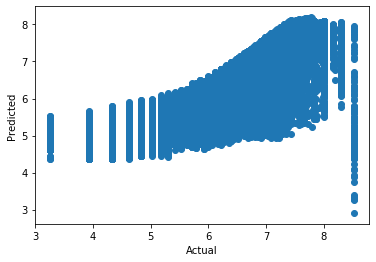

In [68]:
plt.figure()
plt.scatter(y, y_hat)
plt.xlabel("Actual")
plt.ylabel("Predicted");

### 2. Normality of the errors

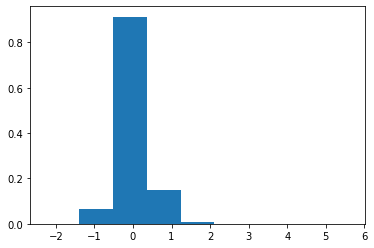

In [76]:
plt.hist(residuals, density=True, bins=9);

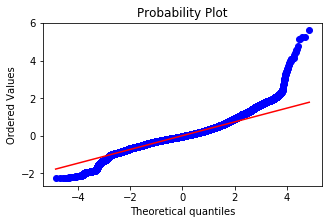

In [62]:
import scipy as sp
fig, ax = plt.subplots(figsize=(5,3))
sp.stats.probplot(residuals, plot=ax, fit=True);

### 3. No autocorrelation of the error term

In [63]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residuals)

1.9930337662144504

### 4. Homoskedasticity

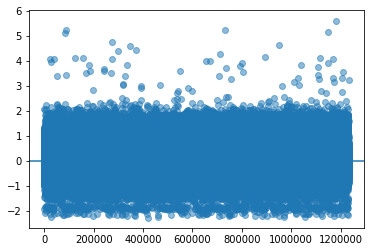

In [64]:
plt.scatter(np.arange(0,len(residuals),1), residuals, alpha=0.5)
plt.axhline(0);

### 5. Exogeneity

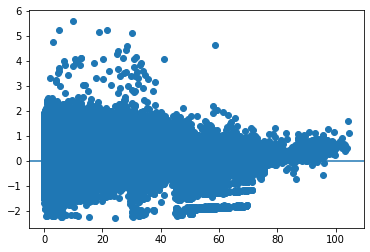

In [65]:
plt.scatter(data.days_to_funding, residuals)
plt.axhline(0);

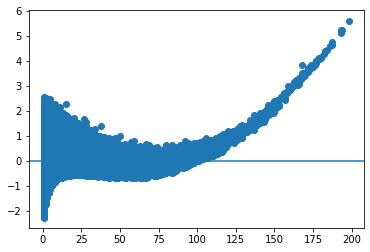

In [66]:
plt.scatter(data.NUM_LENDERS_TOTAL, residuals)
plt.axhline(0);